In [17]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.special import erf, erfc
from scipy.integrate import quad
from scipy.interpolate import interp1d
from matplotlib import rc
from matplotlib.ticker import LogFormatter

plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

hplanck = 6.6260700404e-34  	#Joule*sec
hbar = hplanck/6.283185
clight = 299792458              #m/sec 
kb = 1.38064852e-23			    #Joule/K
G_Newtonian = 6.673*1e-11       #gravity, m^3/kg/s^2

J2GeV = 6.242*1e9               #Joule to GeV
K2GeV = 8.617*1e-14             #Kelvin to GeV
hbarGeV = hbar * J2GeV          #GeV * sec
Invhbar = 1.0/hbar              #Joule^-1*sec-1
InvhbarGeV = Invhbar / J2GeV

GBF_10_10 = np.loadtxt("/Users/yuangw/Documents/GitHub/GBF/test/GBF_s=1_l=1.txt")
GBF_10_20 = np.loadtxt("/Users/yuangw/Documents/GitHub/GBF/test/GBF_s=1_l=2.txt")
GBF_10_30 = np.loadtxt("/Users/yuangw/Documents/GitHub/GBF/test/GBF_s=1_l=3.txt")
GBF_10_40 = np.loadtxt("/Users/yuangw/Documents/GitHub/GBF/test/GBF_s=1_l=4.txt")
omega0, s10l0, s10l1, s10l2, s10l3 = GBF_10_10[:, 0], GBF_10_10[:, 1], GBF_10_20[:, 1], GBF_10_30[:, 1], GBF_10_40[:, 1]
s10l = [s10l0, s10l1, s10l2, s10l3]
s10_array = np.column_stack((s10l0, s10l1, s10l2, s10l3)) 

schwarzschild_spectra = pd.read_csv("/Users/yuangw/Documents/GitHub/GBF/test/schwarzschild_spectra.csv", header=None, names=['x1', 'y1'])
x1 = schwarzschild_spectra['x1'].values
y1 = schwarzschild_spectra['y1'].values
energy_ini = np.logspace(np.log10(x1.min()), np.log10(x1.max()), 200)  # Define energy1 grid

observation_flux = pd.read_csv("/Users/yuangw/Documents/GitHub/GBF/test/observation-flux.csv", header=None, names=['x2', 'y2'])
x2 = observation_flux['x2'].values
y2 = observation_flux['y2'].values

fPBH_mass = pd.read_csv("/Users/yuangw/Documents/GitHub/GBF/test/fPBH-mass.csv", header=None, names=['x3', 'y3'])
x3 = fPBH_mass['x3'].values
y3 = fPBH_mass['y3'].values

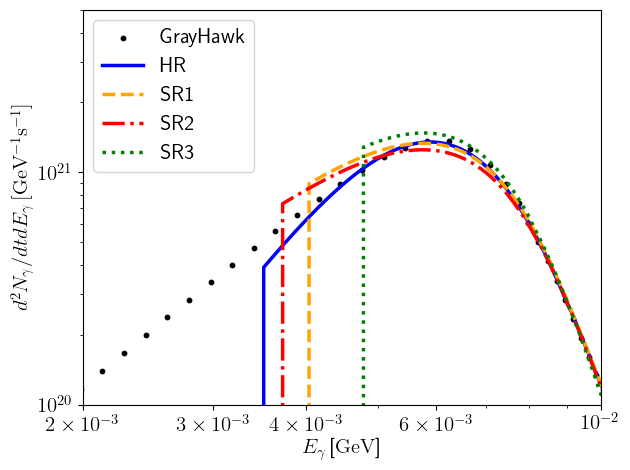

In [31]:
def temperature(mass): #Hawking temperature, input unit is kg
    return hbar * clight**3 / (8 * np.pi * G_Newtonian * kb * mass) * K2GeV # kelvin to GeV

def energy(omega, mass):
    factor = hbar * clight**3 /(G_Newtonian*mass) * J2GeV  # GeV
    return omega * factor

def sum_gamma10(omega, mass):
    k0=1/4
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2*sum((2*(l+1) + 1) * s10l[l] / (np.exp(2*np.pi*omega/k0) - 1) for l in range(4) )/(2*np.pi) 
    return result * InvhbarGeV

def spectra(omega, mass):
    temp = temperature(mass) #GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV 
    result = 2*sum((2*(l+1) + 1) * s10l[l] / (np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV  

def manualfit(omega, l):
    a = -0.790
    b = -2.770
    c = 13.847
    # return 0.5 * (erf(a + b*l + c*omega) + 1.0)
    hr = 0.5 * (erf(a + b*l + c*omega) + 1)   # model values
    nn = s10_array[:, l-1]   # numerical values
    const = np.heaviside(0.25 - np.abs(nn-hr)/nn, 0)
    return  const * hr #+ (1-const) * nn   

def spectra_TP(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * manualfit(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV

def SR1(omega, l):
    a = 1.097
    b = 2.059
    c = -10.293
    # return erf( erfc(a + b*l + c*omega) )
    hr = erf( erfc(a + b*l + c*omega) )  
    nn = s10_array[:, l-1]   # numerical values
    const = np.heaviside(0.25 - np.abs(nn-hr)/nn, 0)
    return  const * hr 

def spectra_SR1(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * SR1(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV

def SR2(omega, l):
    a = 1.097
    b = 2.059
    c = -10.293
    d = 0.554
    # return erf( erfc(a + b*l + c*omega + d*omega**2) )
    hr = erf( erfc(a + b*l + c*omega + d*omega**2) )  
    nn = s10_array[:, l-1]  
    const = np.heaviside(0.25 - np.abs(nn-hr)/nn, 0)
    return  const * hr 
    

def spectra_SR2(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * SR2(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV

def SR3(omega, l):
    a = 1.097
    b = 2.059
    c = -10.293
    d = -0.956
    e = 0.242
    # return erf( erfc(a + b*l + c*omega + d*omega**2 + e*omega**3) )
    hr = erf( erfc(a + b*l + c*omega + d*omega**2 + e*omega**3) )
    nn = s10_array[:, l-1]  
    const = np.heaviside(0.25 - np.abs(nn-hr)/nn, 0)
    return  const * hr 

def spectra_SR3(omega, mass):  # the value of l is 1/2/3/4
    temp = temperature(mass)  # GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2 * sum( (2*(l+1) + 1) * SR3(omega, l+1)/(np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV

ax = plt.gca() # Get current axis
ax.xaxis.set_major_formatter(LogFormatter(labelOnlyBase=True))  

plt.scatter(x1, y1, color='black', s=10, label='GrayHawk')
plt.plot(energy(omega0, 1e13), spectra_TP(omega0,1e13), color='blue', linestyle='-', linewidth=2.5, label='HR')
plt.plot(energy(omega0, 1e13), spectra_SR1(omega0, 1e13), color='orange', linestyle='--', linewidth=2.5, label='SR1')
plt.plot(energy(omega0, 1e13), spectra_SR2(omega0, 1e13), color='red', linestyle='-.', linewidth=2.5, label='SR2')
plt.plot(energy(omega0, 1e13), spectra_SR3(omega0, 1e13), color='green', linestyle=':', linewidth=2.5, label='SR3')
plt.xscale("log")
plt.yscale("log")
plt.xlim(2e-3, 1e-2)
plt.ylim(1e20, 5e21)

plt.xticks([2.e-3, 3.e-3, 4.e-3, 6.e-3, 1.e-2], labels=[r'$2\times10^{-3}$', r'$3\times10^{-3}$', r'$4\times10^{-3}$', r'$6\times10^{-3}$', r'$10^{-2}$'])
# plt.yticks([1.e20, 5.e20, 1.e21, 5.e21], labels=[r'$10^{20}$', r'$5\times10^{20}$', r'$10^{21}$', r'$5\times10^{21}$'])

plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel(r'$E_{\gamma}$\,[{\rm GeV}]', fontsize=15)
plt.ylabel(r'$d^2N_{\gamma}/dtdE_{\gamma}\, [\rm GeV^{-1}s^{-1}]$', fontsize=15)
plt.legend(fontsize=15, loc ='best')

plt.tight_layout()
plt.savefig("spectra.pdf", bbox_inches='tight')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.special import erf, erfc
from scipy.integrate import quad
from scipy.interpolate import interp1d

hplanck = 6.6260700404e-34  	#Joule*sec
hbar = hplanck/6.283185
clight = 299792458              #m/sec 
kb = 1.38064852e-23			    #Joule/K
G_Newtonian = 6.673*1e-11       #gravity, m^3/kg/s^2

J2GeV = 6.242*1e9               #Joule to GeV
K2GeV = 8.617*1e-14             #Kelvin to GeV
hbarGeV = hbar * J2GeV          #GeV * sec
Invhbar = 1.0/hbar              #Joule^-1*sec-1
InvhbarGeV = Invhbar / J2GeV

GBF_10_10 = np.loadtxt("/Users/yuangw/Documents/GitHub/GBF/test/GBF_s=1_l=1.txt")
GBF_10_20 = np.loadtxt("/Users/yuangw/Documents/GitHub/GBF/test/GBF_s=1_l=2.txt")
GBF_10_30 = np.loadtxt("/Users/yuangw/Documents/GitHub/GBF/test/GBF_s=1_l=3.txt")
GBF_10_40 = np.loadtxt("/Users/yuangw/Documents/GitHub/GBF/test/GBF_s=1_l=4.txt")
omega0, s10l0, s10l1, s10l2, s10l3 = GBF_10_10[:, 0], GBF_10_10[:, 1], GBF_10_20[:, 1], GBF_10_30[:, 1], GBF_10_40[:, 1]
# s10l = [s10l0, s10l1, s10l2, s10l3]
s10_array = np.column_stack((s10l0, s10l1, s10l2, s10l3)) 

schwarzschild_spectra = pd.read_csv("/Users/yuangw/Documents/GitHub/GBF/test/schwarzschild_spectra.csv", header=None, names=['x1', 'y1'])
x1 = schwarzschild_spectra['x1'].values
y1 = schwarzschild_spectra['y1'].values
energy_ini = np.logspace(np.log10(x1.min()), np.log10(x1.max()), 200)  # Define energy1 grid

observation_flux = pd.read_csv("/Users/yuangw/Documents/GitHub/GBF/test/observation-flux.csv", header=None, names=['x2', 'y2'])
x2 = observation_flux['x2'].values
y2 = observation_flux['y2'].values

fPBH_mass = pd.read_csv("/Users/yuangw/Documents/GitHub/GBF/test/fPBH-mass.csv", header=None, names=['x3', 'y3'])
x3 = fPBH_mass['x3'].values
y3 = fPBH_mass['y3'].values

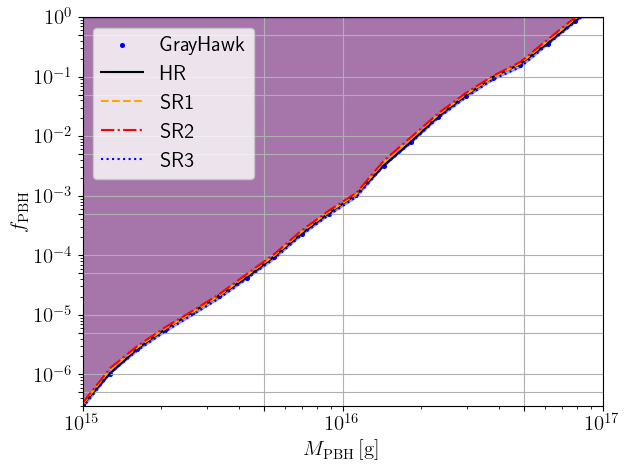

In [40]:
# Constants
H0_s = 2.33e-18       # Hubble constant in seconds, s^-1
Om = 0.2552           # Matter density parameter
z_rec = 500           # Redshift at recombination

def flux_obs(energy_target):
    ff = interp1d(x2, y2, kind='linear', fill_value="extrapolate")
    return ff(energy_target)

def fpbh_obs(mass):
    ff = interp1d(x3, y3, kind='linear', fill_value="extrapolate")
    return ff(mass)

def temperature(mass): #Hawking temperature, input unit is kg
    return hbar * clight**3 / (8 * np.pi * G_Newtonian * kb * mass) * K2GeV # kelvin to GeV

def energy(omega, mass):
    factor = hbar * clight**3 /(G_Newtonian*mass) * J2GeV  # GeV
    return omega * factor

def spectra(omega, mass):
    temp = temperature(mass) #GeV
    factor1 = (hbar * clight**3 * J2GeV)/(G_Newtonian*mass)
    energy = omega*factor1     # GeV
    result = 2*sum((2*(l+1) + 1) * s10l[l] / (np.exp(energy/temp) - 1) for l in range(4) )/(2*np.pi)
    return result * InvhbarGeV

def flux_rescaling(z, energy_target, omega, mass):
    # spectra_input = spectra(omega, mass)
    spectra_input = spectra_SR3(omega, mass)
    energy0 = energy(omega, mass)
    temp_energy = energy0 / (1+z)
    flux_interp = interp1d(temp_energy, spectra_input, kind='linear', bounds_error=False, fill_value=0)
    return flux_interp(energy_target)


# Hubble parameter function 
def H(z):
    """Hubble parameter as a function of redshift z."""
    return H0_s * np.sqrt(Om * (1 + z)**3 + (1 - Om))   # s^-1 

# Luminosity function
def lum_vec(energy_target, omega, mass, npbh=1e-50):   # npbh is the number density of PBH, cm^-3 
    def lum_single(energy_target):
        """Compute luminosity for a given energy target."""
        def integrand(z):
            rescaled_flux = flux_rescaling(z, energy_target, omega, mass)
            return rescaled_flux / H(z)
    
        result, _ = quad(integrand, 0, z_rec)
        lum = npbh * energy_target/np.pi * result * (clight*1e2) / (4*np.pi)     
        return lum  # cm^-2 s^-1 sr^-1, the present number density of photons with energy_target
    
    lum_values = np.vectorize(lum_single)(energy_target)
    max_lum = np.max(lum_values)
    max_energy = energy_target[np.argmax(lum_values)]
    obs = flux_obs(max_energy)
    
    return np.log10(obs/max_lum)-50

def lum(energy_target, omega, mass):   # npbh is the number density of PBH, cm^-3 
    def lum_single(energy_target):
        """Compute luminosity for a given energy target."""
        def integrand(z):
            rescaled_flux = flux_rescaling(z, energy_target, omega, mass)
            return rescaled_flux / H(z)
    
        lognpbh = lum_vec(energy(omega0, mass), omega0, mass)
        npbh0 = 10 ** lognpbh
        result, _ = quad(integrand, 0, z_rec)
        lum = npbh0 * energy_target/np.pi * result * clight / (4 * np.pi)     
        return lum   # cm^-2 s^-1 sr^-1, the present number density of photons with energy_target
    
    return np.vectorize(lum_single)(energy_target)

def fpbh(mass):
    rho0 = 9.74 * 1e-33  # Dark matter density (kg/cm^3)
    lognpbh = lum_vec(energy(omega0, mass), omega0, mass)
    Npbh = 10 ** lognpbh
    return Npbh * mass/rho0

# mass0 = np.logspace(12, 14, 20)
# fpbh_value = []
# for m in mass0:
#     fpbh0 = fpbh(m)
#     print(m, fpbh0)
#     fpbh_value.append(fpbh0)


fpbh0 = np.loadtxt("/Users/yuangw/Documents/GitHub/GBF/test/fpbh_grayhawk.txt")
x4, y4 = fpbh0[:, 0], fpbh0[:, 1]

fpbh_tp = np.loadtxt("/Users/yuangw/Documents/GitHub/GBF/test/fpbh_tp.txt")
xtp, ytp = fpbh_tp[:, 0], fpbh_tp[:, 1]

fpbh_sr1 = np.loadtxt("/Users/yuangw/Documents/GitHub/GBF/test/fpbh_sr1.txt")
xsr1, ysr1 = fpbh_sr1[:, 0], fpbh_sr1[:, 1]

fpbh_sr2 = np.loadtxt("/Users/yuangw/Documents/GitHub/GBF/test/fpbh_sr2.txt")
xsr2, ysr2 = fpbh_sr2[:, 0], fpbh_sr2[:, 1]

fpbh_sr3 = np.loadtxt("/Users/yuangw/Documents/GitHub/GBF/test/fpbh_sr3.txt")
xsr3, ysr3 = fpbh_sr3[:, 0], fpbh_sr3[:, 1]

# fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [8,1]})

# # axs[0].plot(x3, y3, color='red', label='2409.02804')
# axs[0].scatter(x4, y4, color='blue', s=7, label='GrayHawk')
# axs[0].plot(xtp, ytp, color='black', linestyle='-', label='TP')
# axs[0].plot(xsr1, ysr1, color='orange', linestyle='--', label='SR1')
# axs[0].plot(xsr2, ysr2, color='red', linestyle='-.', label='SR2')
# axs[0].plot(xsr3, ysr3, color='blue', linestyle=':', label='SR3')
# axs[0].xlabel(r'$M_{pbh}$[kg]')
# axs[0].ylabel(r'$f_{pbh} \equiv \Omega_{phb}/\Omega_{dm}$')
# axs[0].xlim(1e12, 2e14)
# axs[0].ylim(1e-7, 1)
# axs[0].xscale('log')
# axs[0].yscale('log')
# # axs[0].title("Fraction of Dark Matter from PBHs")
# axs[0].grid(True, which="both", ls="--")
# axs[0].legend(loc='upper left')

# plt.plot(x3, y3, color='red', label='2409.02804')
plt.scatter(1000*x4, y4, color='blue', s=7, label='GrayHawk')
plt.plot(1000*xtp, ytp, color='black', linestyle='-', label='HR')
plt.plot(1000*xsr1, ysr1, color='orange', linestyle='--', label='SR1')
plt.plot(1000*xsr2, ysr2, color='red', linestyle='-.', label='SR2')
plt.plot(1000*xsr3, ysr3, color='blue', linestyle=':', label='SR3')

plt.fill_between(1000*xtp, ytp, 1, color='black', alpha=0.1)
plt.fill_between(1000*xsr1, ysr1, 1, color='orange', alpha=0.25)
plt.fill_between(1000*xsr2, ysr2, 1, color='red', alpha=0.2)
plt.fill_between(1000*xsr3, ysr3, 1, color='blue', alpha=0.3)

# plt.xlabel(r'$M_{PBH}$[g]')
# plt.ylabel(r'$f_{PBH}$')
plt.xlabel(r'$M_{\rm PBH}\,[{\rm g}]$', fontsize=15)
plt.ylabel(r'$f_{\rm PBH}$', fontsize=15)
plt.xlim(1e15, 1e17)
plt.ylim(3e-7, 1)
plt.xscale('log')
plt.yscale('log')
# plt.title("Fraction of Dark Matter from PBHs")
plt.tick_params('x', labelsize=15)
plt.tick_params('y', labelsize=15)
plt.xticks([1.e15,5.e15,1.e16,5.e16,1.e17])
plt.yticks([5.e-7,1.e-6,5.e-6,1.e-5,5.e-5,1.e-4,5.e-4,1.e-3,5.e-3,1.e-2,5.e-2,1.e-1,5.e-1,1.e0])
plt.grid()
plt.legend(fontsize=15, loc ='best')

plt.tight_layout()
plt.savefig("fpbh.pdf", bbox_inches="tight")
plt.show()